In [1]:
# !nvcc --version

In [2]:
# ### For Colab, install dependencies.

# !pip install mxnet-cu101==1.7 
# !pip install gluonts
# !pip install fredapi
# !pip install stats-can
# !pip install --upgrade scikit-learn

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# %cd /content/drive/MyDrive/Colab Notebooks/foodprice-forecasting
# !pwd

In [5]:
import pandas as pd
pd.set_option('precision', 3)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import numpy as np
import pickle
import data

import importlib
importlib.reload(data)

from data import update_expl_data, update_target_data, food_categories, preprocess_expl
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import os

In [6]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]
output_path = "./output/nbeats_202110"
if not os.path.exists(output_path):
    os.mkdir(output_path)

## Load Data Using APIs

In [7]:
"""
Load food CPI data from January 1986 to the most recently available data.
"""

# foodprice_df = update_target_data(food_categories, './data_files/food_cpi.csv')
foodprice_df = pd.read_csv("./data_files/food_cpi.csv")
foodprice_df = foodprice_df.set_index("REF_DATE")
foodprice_df.index = pd.DatetimeIndex(foodprice_df.index)
foodprice_df = foodprice_df.resample(frequency).mean().interpolate()
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations
REF_DATE,,,,,,,,,
1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0
1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4
1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3
...,...,...,...,...,...,...,...,...,...
2021-04-01,156.2,146.1,145.1,163.2,155.4,141.9,173.5,140.5,151.1
2021-05-01,157.8,146.6,147.6,163.5,156.6,143.9,175.4,141.6,153.8
2021-06-01,157.7,145.3,146.2,163.9,156.8,144.5,176.7,142.2,153.4


# NBEATS Model and Experiments

## Data Splitting

For each such candidate forecast, we should record any uncertainty/confidence metrics it provides, and evaluation metrics for that same model configuration over the test set. i.e. When model configuration XYZ was used to forecast Meat prices over the test set (with that data not being used for training or validation!) - what were its evaluation metrics on the withheld data? We should report this consistently for ALL EXPERIMENTS. 

For all models, we will use the following "simulated" report dates. This is a form of cross validation over time. We train a model up to each cutoff date, and then produce and evaluate 18-month forecasts. We can then collect each model's validation metric, take the mean, and use this to do model selection for the final forecast (or ensemble of forecasts!).

In [8]:
report_sim_dates = ["2015-07-01", "2016-07-01", "2017-07-01", "2018-07-01", "2019-07-01", "2020-07-01"]

In [9]:
sim_train_dates = {}
sim_valid_dates = {}

for date in report_sim_dates:
    sim_train_dates[date] = foodprice_df.index[foodprice_df.index <= date]
    sim_valid_dates[date] = foodprice_df.index[(foodprice_df.index > date) & (foodprice_df.index <= (pd.to_datetime(date) + pd.DateOffset(months=18)))]

## Fitting and Evaluating a Single NBEATS Model: Example Using All Food Prices

In [10]:
# N = foodprice_df.shape[1]
# T = foodprice_df.shape[0]
# prediction_length = 18
# freq = "MS"
# dataset = foodprice_df.T.values
# start = pd.Timestamp("2016-07-01", freq=freq)

In [11]:
from gluonts.dataset.common import ListDataset

# # train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
# train_ds = ListDataset(
#     [{'target': x, 'start': start} for x in dataset[:, :-prediction_length]],
#     freq=freq
# )
# # valid dataset: use the whole dataset, add "target" and "start" fields
# valid_ds = ListDataset(
#     [{'target': x, 'start': start} for x in dataset],
#     freq=freq
# )



In [12]:
# next(iter(valid_ds))

In [13]:
# dataset.shape

In [14]:
dataset_df = foodprice_df.T
dataset_df

REF_DATE,1986-01-01,1986-02-01,1986-03-01,1986-04-01,1986-05-01,1986-06-01,1986-07-01,1986-08-01,1986-09-01,1986-10-01,...,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01
Bakery and cereal products (excluding baby food),69.3,70.3,70.6,71.3,71.2,71.1,71.7,71.9,71.7,71.1,...,155.2,156.4,154.2,157.1,156.8,156.2,157.8,157.7,157.9,158.5
Dairy products and eggs,70.9,70.8,71.1,71.0,71.4,71.1,71.3,71.5,71.8,71.8,...,141.6,141.5,141.6,143.1,144.9,146.1,146.6,145.3,146.4,148.3
"Fish, seafood and other marine products",60.6,61.3,61.3,61.4,61.9,62.0,62.2,62.7,63.1,63.6,...,145.0,144.7,143.4,143.9,144.9,145.1,147.6,146.2,146.6,146.8
Food purchased from restaurants,59.1,59.1,59.3,59.7,59.9,60.0,60.6,60.9,60.9,61.3,...,161.6,161.6,162.6,162.9,162.6,163.2,163.5,163.9,165.2,165.9
Food,67.3,66.9,67.0,67.7,68.2,68.4,69.2,69.5,69.9,70.2,...,153.9,153.6,155.0,155.6,155.5,155.4,156.6,156.8,157.6,158.0
"Fruit, fruit preparations and nuts",76.0,77.6,79.2,82.2,83.5,83.1,84.8,86.7,83.8,82.9,...,139.6,140.0,140.9,143.4,142.4,141.9,143.9,144.5,141.7,142.5
Meat,65.1,64.2,64.2,63.6,64.0,64.9,66.5,67.8,71.3,71.5,...,170.9,170.0,171.9,169.5,170.2,173.5,175.4,176.7,180.9,182.1
Other food products and non-alcoholic beverages,77.5,78.1,78.6,79.5,79.8,79.9,80.2,80.2,80.8,81.0,...,138.1,136.5,139.0,139.5,141.5,140.5,141.6,142.2,141.9,141.7
Vegetables and vegetable preparations,76.0,68.4,66.2,71.1,75.3,74.1,75.7,71.9,66.6,70.7,...,156.8,157.1,162.5,163.8,157.4,151.1,153.8,153.4,154.8,152.2


In [15]:
# # valid dataset: use the whole dataset, add "target" and "start" fields
# report_sim_date = "2016-07-01"
# report_train_dates = sim_train_dates[report_sim_date]
# report_valid_dates = sim_valid_dates[report_sim_date]

# valid_ds_report = ListDataset(
#     [{'target': x, 'start': start} for x in dataset_df[report_valid_dates].values],
#     freq=freq
# )


In [16]:
# next(iter(valid_ds_report))

In [17]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = {
    'r2_score': r2_score,
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error,
    'mse': mean_squared_error,
    'rmse': rmse
}
def get_prophet_df(foodprice_df, food_category, dates):
    df = foodprice_df[food_category][dates]
    df = df.reset_index()
    df = df.rename({'REF_DATE':'ds', food_category:'y'}, axis=1)
    return df

In [18]:
import mxnet as mx
from gluonts.model.n_beats import NBEATSEnsembleEstimator
from gluonts.mx import Trainer
from gluonts.dataset.common import ListDataset

prediction_length = 18

In [19]:
# predictor = estimator.train(train_ds)

In [20]:
from gluonts.evaluation import make_evaluation_predictions

def train_eval_nbeats(report_sim_date):

    report_train_dates = sim_train_dates[report_sim_date]
    report_valid_dates = sim_valid_dates[report_sim_date]
    
    # train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
    train_ds = ListDataset(
        [{'target': x, 'start': report_sim_date} for x in dataset_df[list(report_train_dates)].values],
        freq='MS'
    )

    valid_ds_report = ListDataset(
        [{'target': x, 'start': report_sim_date} for x in dataset_df[list(report_train_dates) + list(report_valid_dates)].values],
        freq='MS'
    )

    estimator = NBEATSEnsembleEstimator(
        prediction_length=prediction_length,
        #context_length=7*prediction_length,
        meta_bagging_size = 3,  # 3
        meta_context_length = [prediction_length * m for m in [3,5,7] ], 
        meta_loss_function = ['sMAPE'], 
        num_stacks = 30,
        widths= [512],
        freq="MS",
        trainer=Trainer(
                    # learning_rate=6e-4,
                    #clip_gradient=1.0,
                    epochs=50,
                    # num_batches_per_epoch=1000,
                    # batch_size=16,
                    ctx=mx.context.gpu()
                )

    )

    predictor = estimator.train(train_ds)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=valid_ds_report,  # test dataset
        predictor=predictor,  # predictor
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    all_fc_dates = list(report_train_dates) + list(report_valid_dates)

    all_food_metrics = {}
    food_forecasts = {}

    for target_index in range(len(forecasts)):

        # Get food price category
        foodprice_category = foodprice_df.columns[target_index]

        # plot actual
        fig, ax = plt.subplots(figsize=(8,3))
        ax.scatter(all_fc_dates, foodprice_df[foodprice_category][all_fc_dates], color='black')

        # plot forecast
        forecast_entry = forecasts[target_index]
        ax.plot(report_valid_dates, forecast_entry.mean[:len(report_valid_dates)], color='C0')

        plt.title(f"{foodprice_category}, {report_sim_date}")
        plt.grid()
        plt.show()

        fc_metrics = {}
        for metric_name, metric_fn in metrics.items():
            print(metric_name, metric_fn)
            y_true = foodprice_df[foodprice_category][report_valid_dates]
            y_pred = forecast_entry.mean[:len(report_valid_dates)]
            score = metric_fn(y_true=y_true, y_pred=y_pred)
            print(metric_name, score)
            fc_metrics[metric_name] = score

        # fc_metrics = pd.Series({metric_name: metric_fn(y_true=foodprice_df[foodprice_category][report_valid_dates], y_pred=forecast_entry.mean[:len(report_valid_dates)]) for metric_name, metric_fn in metrics.items()})
        # print(fc_metrics)

        all_food_metrics[foodprice_category] = fc_metrics
        food_forecasts[foodprice_category] = pd.Series(forecast_entry.mean[:len(report_valid_dates)], index=report_valid_dates, name=foodprice_category)

        # print(valid_df)
        # print(valid_forecast)

    all_forecasts = pd.DataFrame(food_forecasts)
    all_forecasts.to_csv(f"{output_path}/forecasts_{report_sim_date}.csv")

    return all_food_metrics, all_forecasts

TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("gpu", 0), epochs=50, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=10, weight_decay=1e-08)


/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/dataset/common.py:337: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return timestamp.freq.rollforward(timestamp)
  0%|          | 0/50 [00:00<?, ?it/s]/home/ethan/anaconda3/envs/forecasting/lib/python3.8/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/ethan/anaconda3/envs/fo

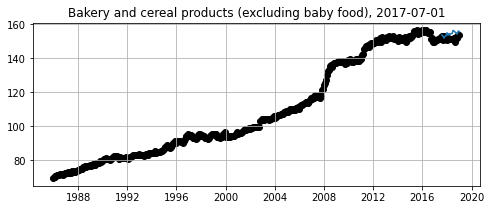

r2_score <function r2_score at 0x7f1ee60b6670>
r2_score -7.8471734694454405
mae <function mean_absolute_error at 0x7f1ee60a9550>
mae 2.672830878363715
mape <function mean_absolute_percentage_error at 0x7f1ee60b63a0>
mape 0.01764242364035589
mse <function mean_squared_error at 0x7f1ee60b6430>
mse 9.149998018137282
rmse <function rmse at 0x7f1f5c214820>
rmse 3.0248963648590146


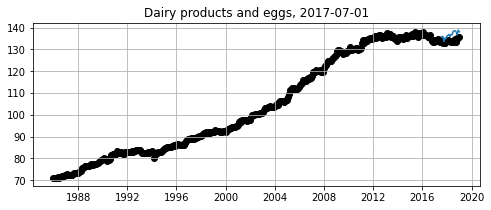

r2_score <function r2_score at 0x7f1ee60b6670>
r2_score -11.401722248984145
mae <function mean_absolute_error at 0x7f1ee60a9550>
mae 2.765893385145399
mape <function mean_absolute_percentage_error at 0x7f1ee60b63a0>
mape 0.02064483801820053
mse <function mean_squared_error at 0x7f1ee60b6430>
mse 8.763883722615427
rmse <function rmse at 0x7f1f5c214820>
rmse 2.9603857388211128


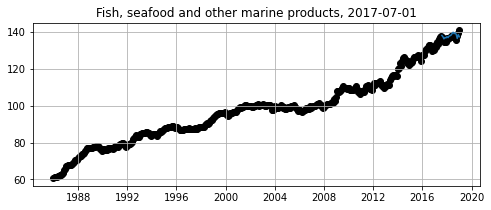

r2_score <function r2_score at 0x7f1ee60b6670>
r2_score -0.14878212551995063
mae <function mean_absolute_error at 0x7f1ee60a9550>
mae 1.5362884521484388
mape <function mean_absolute_percentage_error at 0x7f1ee60b63a0>
mape 0.011219792623909937
mse <function mean_squared_error at 0x7f1ee60b6430>
mse 3.095506897176515
rmse <function rmse at 0x7f1f5c214820>
rmse 1.7594052680313639


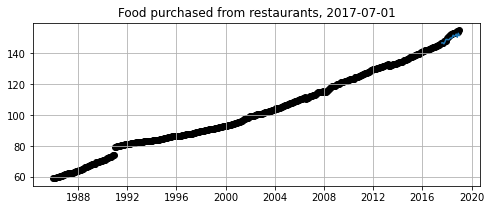

r2_score <function r2_score at 0x7f1ee60b6670>
r2_score 0.4481132564924808
mae <function mean_absolute_error at 0x7f1ee60a9550>
mae 1.6715818617079004
mape <function mean_absolute_percentage_error at 0x7f1ee60b63a0>
mape 0.010975628976614438
mse <function mean_squared_error at 0x7f1ee60b6430>
mse 3.8179661184181963
rmse <function rmse at 0x7f1f5c214820>
rmse 1.9539616471205867


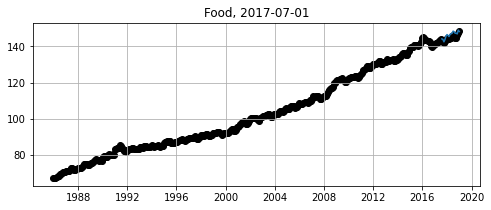

r2_score <function r2_score at 0x7f1ee60b6670>
r2_score -0.06390105889460096
mae <function mean_absolute_error at 0x7f1ee60a9550>
mae 1.5920834011501752
mape <function mean_absolute_percentage_error at 0x7f1ee60b63a0>
mape 0.010995455593691172
mse <function mean_squared_error at 0x7f1ee60b6430>
mse 2.9895619754938245
rmse <function rmse at 0x7f1f5c214820>
rmse 1.729034983883734


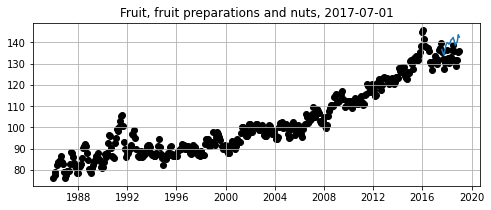

r2_score <function r2_score at 0x7f1ee60b6670>
r2_score -4.236795215387336
mae <function mean_absolute_error at 0x7f1ee60a9550>
mae 6.347743394639758
mape <function mean_absolute_percentage_error at 0x7f1ee60b63a0>
mape 0.047974058705500325
mse <function mean_squared_error at 0x7f1ee60b6430>
mse 46.06715005876704
rmse <function rmse at 0x7f1f5c214820>
rmse 6.787278545836103


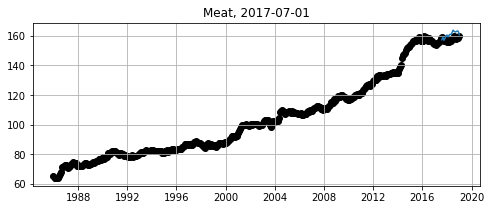

r2_score <function r2_score at 0x7f1ee60b6670>
r2_score -7.9461807545956535
mae <function mean_absolute_error at 0x7f1ee60a9550>
mae 3.201476372612848
mape <function mean_absolute_percentage_error at 0x7f1ee60b63a0>
mape 0.020287260856058826
mse <function mean_squared_error at 0x7f1ee60b6430>
mse 12.97334267761352
rmse <function rmse at 0x7f1f5c214820>
rmse 3.601852672946732


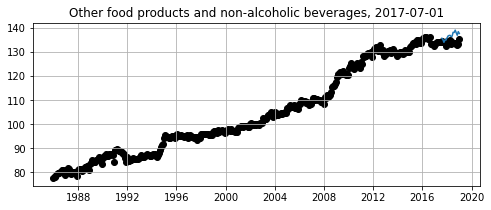

r2_score <function r2_score at 0x7f1ee60b6670>
r2_score -18.834969790307184
mae <function mean_absolute_error at 0x7f1ee60a9550>
mae 2.726241726345483
mape <function mean_absolute_percentage_error at 0x7f1ee60b63a0>
mape 0.020380557617642243
mse <function mean_squared_error at 0x7f1ee60b6430>
mse 9.700157294056053
rmse <function rmse at 0x7f1f5c214820>
rmse 3.11450755241596


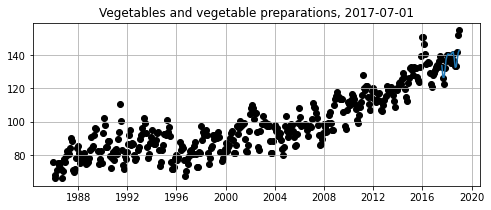

r2_score <function r2_score at 0x7f1ee60b6670>
r2_score 0.6573083562141547
mae <function mean_absolute_error at 0x7f1ee60a9550>
mae 2.858178117540148
mape <function mean_absolute_percentage_error at 0x7f1ee60b63a0>
mape 0.020053494575621073
mse <function mean_squared_error at 0x7f1ee60b6430>
mse 18.754085782550217
rmse <function rmse at 0x7f1f5c214820>
rmse 4.330598778754529


In [21]:
all_valid_metrics = {}
all_forecasts = {}

for report_sim_date in report_sim_dates:
    valid_metrics, forecasts = train_eval_nbeats(report_sim_date)
    all_valid_metrics[report_sim_date] = valid_metrics
    all_forecasts[report_sim_date] = forecasts

In [25]:
valid_metrics_concat = {}

all_valid_metrics.keys()

for report_date, valid_scores in all_valid_metrics.items():
    valid_metrics_concat[report_date] = pd.DataFrame(valid_scores).T
index = valid_metrics_concat[report_date].index
columns = valid_metrics_concat[report_date].columns
scores = [df.values for date, df in valid_metrics_concat.items()]
mean_scores = pd.DataFrame(np.array(scores).mean(axis=0), index=index, columns=columns)
mean_scores.to_csv(f"{output_path}/mean_fc_valid_metrics.csv")
mean_scores

,r2_score,mae,mape,mse,rmse
Bakery and cereal products (excluding baby food),-7.847,2.673,0.018,9.150,3.025
Dairy products and eggs,-11.402,2.766,0.021,8.764,2.960
"Fish, seafood and other marine products",-0.149,1.536,0.011,3.096,1.759
Food purchased from restaurants,0.448,1.672,0.011,3.818,1.954
Food,-0.064,1.592,0.011,2.990,1.729
"Fruit, fruit preparations and nuts",-4.237,6.348,0.048,46.067,6.787
Meat,-7.946,3.201,0.020,12.973,3.602
Other food products and non-alcoholic beverages,-18.835,2.726,0.020,9.700,3.115
Vegetables and vegetable preparations,0.657,2.858,0.020,18.754,4.331


## Fit Models Using All Data To Produce Final Forecast

## Predicted Change in CPI By Category

For the report, we usually express forecasts as the predicted percentage change, overall for the next year. We can do this by comparing the mean forecasted CPI for 2022 to the mean (known and predicted) values for 2021.